# Cyft Data Investigation

Goal:


#### Description:

_30-Day All-Cause Hospital Readmissions_ is a quality measure that many healthcare organizations use to track their performance. Lower readmission rates indicate better patient outcomes, while higher ones tend to indicate system problems that are negatively impacting patients. The goal of this exercise is to analyze a dataset that simulates hospitalizations for a geriatric patient population in 2015 and 2016 to predict __if a patient is likely to have a readmission based on the information available at the time of their initial admission.__

You have 3 hours to complete the exercise. If you don't get through all the objectives, that's OK. After 3 hours, please finish what you're working on and send in whatever code, analyses, and visualizations (such as images) you have available. Include comments documenting any assumptions you've made as well as other ideas you would have tried if you had more time.

Feel free to use the language and statistical/machine learning libraries that you are most comfortable with, and ask questions along the way if any clarifications are necessary.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
import seaborn as sns

/Users/xbno/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/xbno/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
Dxs_summarized = {'A41': 'Sepsis',
 'E11': 'diabetes mellitus',
 'E56': 'Vitamin deficiency',
 'E86': 'Dehydration',
 'F03': 'dementia',
 'F05': 'Delirium',
 'F19': 'Drug abuse',
 'G31': 'Degeneration of nervous system',
 'G89': 'Chronic Pain',
 'H53': 'Visual discomfort',
 'H91': 'Hearing loss',
 'I10': 'hypertension',
 'I50': 'Heart Failure',
 'I51': 'heart disease',
 'J18': 'Pneumonia',
 'J44': 'COPD',
 'J45': 'asthma',
 'M54': 'Radiculopathy/Panniculitis/Sciatica',
 'N18': 'Chronic kidney disease',
 'N39': 'Urinary incontinence',
 'R05': 'cough',
 'R26': 'abnormalities of gait and mobility',
 'R39': 'Urgency of urination',
 'R41': 'Cognitive functions and awareness symptoms',
 'R51': 'headache',
 'T88': 'Anesthesia Complication',
 'W19': 'Fall'}

In [6]:
def add_target(full):
    full['Readmitted'] = full.groupby(['Patient'])['Patient'].transform('count')
    full['Readmitted'] = full['Readmitted'].map({2:1,1:0})
    full['DaysSinceAdmission'] = full[full['Readmitted'] == 1].groupby(['Patient']).diff()['AdmitDate']
    full['<=30Days'] = (full['DaysSinceAdmission'] <= pd.Timedelta('30 days')).astype(np.int)
    full['WillBe<=30Days'] = full[full['Readmitted'] == 1].groupby('Patient').shift(-1)[['<=30Days']].fillna(0).astype(np.int)
    full['WillBe<=30Days'] = full['WillBe<=30Days'].fillna(0)
    full['<=30Days'] = full['WillBe<=30Days']
    full.drop(['Readmitted','DaysSinceAdmission','WillBe<=30Days'],axis=1,inplace=True)
    return full

In [7]:
def add_combined_dx_feats(full_orig):
    full_orig['PrimaryDx_Dx2'] = full_orig['PrimaryDx']+full_orig['Dx2']
    full_orig['PrimaryDx_Dx3'] = full_orig['PrimaryDx']+full_orig['Dx3']
    full_orig['Dx2_Dx3'] = full_orig['Dx2']+full_orig['Dx3']
    return full_orig

In [8]:
def add_month_feat(df):
    df['MonthAdmit'] = df['AdmitDate'].apply(lambda x: x.month)
    df['MonthAdmit'] = df['MonthAdmit'].map({1:'Jan',
                                            2:'Feb',
                                            3:'Mar',
                                            4:'Apr',
                                            5:'May',
                                            6:'Jun',
                                            7:'Jul',
                                            8:'Aug',
                                            9:'Sep',
                                            10:'Oct',
                                            11:'Nov',
                                            12:'Dec'})
    return df

In [9]:
def replace_nulls(full):
    full = full.replace('@NA',np.NaN) # replace @NA
    full = full.replace('',np.NaN) # didn't find any empty strings
    full = full.replace(np.NaN,'')
    return full

#### Load and transform data

Functions created in other eda notebook and copied over

In [10]:
admit = pd.read_csv('../../Cyft/readmissions/admissions.csv')
claims = pd.read_csv('../../Cyft/readmissions/claims.csv')

full = pd.merge(admit,claims,on=['Patient','AdmitDate'])
full['AdmitDate'] = pd.to_datetime(full['AdmitDate'])

full = replace_nulls(full)
full = add_target(full)
#full = add_combined_dx_feats(full)
full = add_month_feat(full)

In [11]:
full_orig = full.copy()

full = full.set_index('AdmitDate')

for col in [col for col in full.columns if full[col].dtype == 'object' and 'Patient' not in col]:
    dummies = pd.get_dummies(full[col],prefix=col)
    full.drop(col,axis=1,inplace=True)
    full = pd.concat([full,dummies],axis=1)    

In [12]:
train = full['2015']
test = full['2016']

train = train.drop(['Patient'],axis=1)
test = test.drop(['Patient'],axis=1)

print('train: {} rows and {} columns'.format(*train.shape))
print('test: {} rows and {} columns'.format(*test.shape))

train: 2856 rows and 49 columns
test: 2938 rows and 49 columns


In [13]:
print('Accuracy baseline is: {:.2f}%'.format(100*(1-full['<=30Days'].mean())))


Accuracy baseline is: 76.44%


In [14]:
# X_train = train[top_feats]
# y_train = train['<=30Days']
# X_test = test[top_feats]
# y_test = test['<=30Days']

In [15]:
X_train = train.drop(['<=30Days'],axis=1)
y_train = train['<=30Days']
X_test = test.drop(['<=30Days'],axis=1)
y_test = test['<=30Days']

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

#### Stacking

In [16]:
from sklearn.cross_validation import KFold

In [17]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 10 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        #params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [108]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_fold = x_train[train_index]
        y_fold = y_train[train_index]
        x_outfold = x_train[test_index]

        clf.train(x_fold, y_fold)

        oof_train[test_index] = clf.predict(x_outfold)
        oof_test_skf[i, :] = clf.predict(x_test)

    #oof_test[:] = oof_test_skf.mean(axis=0)
    #oof_test[:] = oof_test_skf.mean(axis=0)
    #print(oof_test_skf)
    return oof_train, oof_test_skf
    #return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [109]:
knn_params = {
    'n_neighbors': 5,
    'weights': 'distance',
    'p': 1
}

lr_params = {
    'random_state': 0,
    'C': 1,
    'class_weight': 'balanced',
    'penalty': 'l1'
}

# lr_params = {
#     'class_weight': 'balanced',
# }

rf_params = {
    'random_state': 0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 50,
    'min_samples_split': 80,
    'n_estimators': 400
}

#### Use 3 Models for 1st stage

Create blended predictions of each model's test predictions

In [110]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
knn = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_params)
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)

In [111]:
knn_oof_train, knn_oof_test = get_oof(knn, X_train, y_train, X_test)
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test) 
lr_oof_train, lr_oof_test = get_oof(lr, X_train, y_train, X_test)  

In [128]:
pd.DataFrame(lr_oof_test.mean(axis=0))[0].value_counts()

0.0    1631
1.0    1038
0.9      51
0.1      47
0.7      32
0.8      28
0.3      24
0.2      24
0.5      23
0.6      22
0.4      18
Name: 0, dtype: int64

#### Add out-of-fold predictions to original train/test

In [87]:
oof_train = train.drop(['<=30Days'],axis=1)
oof_train['knn'] = knn_oof_train.astype(int)
oof_train['rf'] = rf_oof_train.astype(int)
oof_train['lr'] = lr_oof_train.astype(int)

In [88]:
oof_test = test.drop(['<=30Days'],axis=1)
oof_test['knn'] = knn_oof_test.astype(int)
oof_test['rf'] = rf_oof_test.astype(int)
oof_test['lr'] = lr_oof_test.astype(int)

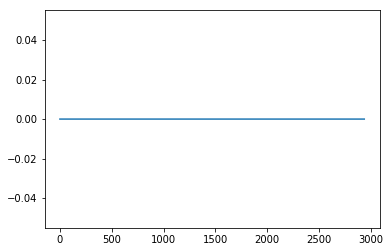

In [91]:
plt.plot(lr_oof_test)

#### Try only preds

In [24]:
oof_train = pd.DataFrame(knn_oof_train.astype(int))
oof_train.columns = ['knn']
oof_train['rf'] = rf_oof_train.astype(int)
oof_train['lr'] = lr_oof_train.astype(int)

In [25]:
oof_test = pd.DataFrame(knn_oof_test.astype(int))
oof_test.columns = ['knn']
oof_test['rf'] = rf_oof_test.astype(int)
oof_test['lr'] = lr_oof_test.astype(int)

#### Only Top Feats

In [26]:
top_feats = ['Age',
 'Dx2_E11',
 'Dx2_E86',
 'Dx2_F03',
 'Dx2_I51',
 'Dx2_T88',
 'Dx2_W19',
 'Dx3_',
 'Dx3_J18',
 'Gender_F',
 'Gender_M',
 'LOS',
 'PastPCPVisits',
 'PrimaryDx_E11',
 'PrimaryDx_I50',
 'PrimaryDx_J44',
 'PrimaryDx_N18']

top_feats = ['Age',
 'Dx2_E11',
 'Dx2_E86',
 'Dx2_F03',
 'Dx2_F05',
 'Dx2_F19',
 'Dx2_G31',
 'Dx2_I51',
 'Dx2_R39',
 'Dx2_T88',
 'Dx2_W19',
 'Dx3_',
 'Dx3_H53',
 'Dx3_J18',
 'Dx3_M54',
 'Dx3_R05',
 'Dx3_R26',
 'Gender_F',
 'Gender_M',
 'LOS',
 'PastPCPVisits',
 'PrimaryDx_A41',
 'PrimaryDx_E11',
 'PrimaryDx_I50',
 'PrimaryDx_J44',
 'PrimaryDx_N18']

In [27]:
oof_train = train[top_feats].copy()
oof_train['knn'] = knn_oof_train.astype(int)
oof_train['rf'] = rf_oof_train.astype(int)
oof_train['lr'] = lr_oof_train.astype(int)
#oof_train['lr'] = oof_train['lr'].map({0:0,1:5})

In [28]:
oof_test = test[top_feats].copy()
oof_test['knn'] = knn_oof_test.astype(int)
oof_test['rf'] = rf_oof_test.astype(int)
oof_test['lr'] = lr_oof_test.astype(int)
#oof_test['lr'] = oof_test['lr'].map({0:0,1:5})

#### Train 2nd stage model

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [30]:
ab = AdaBoostClassifier(base_estimator=LogisticRegression(),n_estimators=1000,learning_rate=1)
ab.fit(oof_train,y_train)
stack_pred = ab.predict(oof_test)

#### For comparisons create standard predictions

In [31]:
lr_pred = LogisticRegression().fit(X_train,y_train).predict(X_test)
knn_pred = KNeighborsClassifier(n_neighbors=5,p=1,weights='distance').fit(X_train,y_train).predict(X_test)
rf_pred = RandomForestClassifier(n_estimators=500).fit(X_train,y_train).predict(X_test)

In [78]:
lr_pred_prob = LogisticRegression().fit(X_train,y_train).predict_proba(X_test)[:,1]
knn_pred_prob = KNeighborsClassifier(n_neighbors=5,p=1,weights='distance').fit(X_train,y_train).predict_proba(X_test)[:,1]
rf_pred_prob = RandomForestClassifier(n_estimators=500).fit(X_train,y_train).predict_proba(X_test)[:,1]

#### Analyze the predictions

This is an interesting outcome. Talk through what the precision vs recall mean and calculate them out if there were real numbers involved

In [32]:
preds = pd.DataFrame(y_test)
preds['knn'] = knn_pred 
preds['knn_blend'] = knn_oof_test.astype(int)
preds['lr'] = lr_pred # standard lr pred
preds['lr blend'] = lr_oof_test.astype(int)
preds['rf'] = rf_pred
preds['rf_blend'] = rf_oof_test.astype(int)
preds['stack'] = stack_pred

In [33]:
for col in [col for col in preds if '<=30Days' not in col]:
    y_pred = preds[col]
    print('Model: {}'.format(col))
    print('\tprecision: {:.3f}\n\trecall: {:.3f}\n\taccuracy: {:.3f}'.format(precision_score(y_test,y_pred),
                                                       recall_score(y_test,y_pred),
                                                       accuracy_score(y_test,y_pred)))

Model: knn
	precision: 0.421
	recall: 0.374
	accuracy: 0.736
Model: knn_blend
	precision: 0.450
	recall: 0.166
	accuracy: 0.760
Model: lr
	precision: 0.586
	recall: 0.415
	accuracy: 0.797
Model: lr blend
	precision: 0.489
	recall: 0.748
	accuracy: 0.761
Model: rf
	precision: 0.553
	recall: 0.309
	accuracy: 0.783
Model: rf_blend
	precision: 0.501
	recall: 0.611
	accuracy: 0.769
Model: stack
	precision: 0.585
	recall: 0.367
	accuracy: 0.793


In [34]:
preds[preds['<=30Days'] == 1].mean()

<=30Days     1.000000
knn          0.374080
knn_blend    0.166421
lr           0.415317
lr blend     0.748159
rf           0.309278
rf_blend     0.611193
stack        0.366716
dtype: float64

#### Graph AUC Curves of models

In [47]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [75]:
def performance(y_true, pred, color="g", ann=True):
    #acc = accuracy_score(y_true, pred)
    auc = roc_auc_score(y_true, pred)
    fpr, tpr, thr = roc_curve(y_true, pred)
    plt.plot(fpr, tpr, color, linewidth="1")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    if ann:
        #plt.annotate("Acc: %0.2f" % acc, (0.2,0.7), size=14)
        plt.annotate("AUC: %0.2f" % auc, (0.2,0.6), size=14)

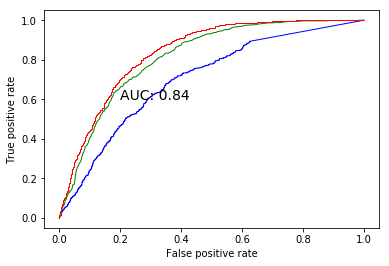

In [81]:
performance(y_test,rf_pred_prob,ann=False)
performance(y_test,knn_pred_prob,color='b',ann=False)
performance(y_test,lr_pred_prob,color='r')

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [39]:
y_test

AdmitDate
2016-01-03    0.0
2016-05-07    1.0
2016-01-14    0.0
2016-10-26    1.0
2016-08-10    0.0
2016-01-02    0.0
2016-12-14    0.0
2016-07-26    1.0
2016-08-26    0.0
2016-10-23    0.0
2016-04-21    0.0
2016-02-20    0.0
2016-11-19    1.0
2016-06-06    0.0
2016-07-15    1.0
2016-10-02    1.0
2016-11-28    0.0
2016-10-21    1.0
2016-02-06    0.0
2016-09-17    0.0
2016-05-21    1.0
2016-09-17    1.0
2016-06-07    0.0
2016-07-29    0.0
2016-03-03    0.0
2016-09-10    1.0
2016-07-16    1.0
2016-06-19    0.0
2016-08-22    0.0
2016-11-18    0.0
             ... 
2016-05-10    0.0
2016-11-06    0.0
2016-06-19    0.0
2016-11-29    0.0
2016-05-22    0.0
2016-09-14    0.0
2016-12-20    0.0
2016-07-02    0.0
2016-03-07    0.0
2016-11-01    0.0
2016-05-18    0.0
2016-06-04    0.0
2016-09-11    0.0
2016-01-18    0.0
2016-05-04    0.0
2016-10-27    0.0
2016-08-21    0.0
2016-11-25    0.0
2016-07-20    0.0
2016-02-28    0.0
2016-05-09    0.0
2016-07-03    0.0
2016-02-15    0.0
2016-04-11    0.0
